In [2]:
# system packages
from datetime import datetime, date, timedelta
import pickle
import warnings
warnings.filterwarnings("ignore")
import platform
import time
from tqdm import tqdm
import os
import boto3
from botocore.client import Config
from botocore import UNSIGNED

# basic packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Patch
import math
from evaluation_table import EvalTable

# model packages
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, train_test_split, RepeatedKFold, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer
from sklearn.preprocessing import MinMaxScaler
import joblib
from shapely.geometry import Point
import geopandas as gpd
import pyproj
from pyproj import datadir
pyproj.datadir.get_data_dir()
datadir.set_data_dir('/home/jovyan/envs/devcon_xgboost/share/proj')  # replace with the actual path to the PROJ data

# Identify the path
home = os.getcwd()
parent_path = os.path.dirname(home)
input_path = f'{parent_path}/02.input/'
output_path = f'{parent_path}/03.output/'
main_path = home

In [3]:
# Load Dataset and Model

# List of station IDs that are of interest.
stations = ['10126000', '10130500', '10134500', '10136500', '10137500', '10141000', '10155000', '10164500', '10171000']

# Read a CSV file into a DataFrame and set the first column as the index.
df = pd.read_parquet(f'{input_path}final_input.parquet')

# Convert the station_id column to string data type.
df.station_id = df.station_id.astype(str)

# Convert the 'datetime' column to datetime objects.
df.datetime = pd.to_datetime(df.datetime)

# Filter the DataFrame to include only the rows where 'station_id' is in the 'stations' list.
df_modified = df[df['station_id'].isin(stations)]
with open(f"{output_path}x_tes.pkl", 'rb') as file:
    x_test_scaled = pickle.load(file)

with open(f"{output_path}y_test.pkl", 'rb') as file:
    y_test_scaled = pickle.load(file)

with open(f"{output_path}best_model_xgboost.pkl", 'rb') as file:
    optimized_xgboost_model = pickle.load(file)

scaler_y= joblib.load(f'{output_path}scaler_y.joblib')

data_test = pd.read_pickle(f"{output_path}test_dataset.pkl")

station_list = list(x_test_scaled.keys())

#### 5.5. Testing the Model
We will give the model the test set for each station and compare it with the observation to evaluate the model with a dataset it has not seen before. Before feeding the test data we load the model. 

In [4]:


# Initialize empty DataFrames to store evaluation results if not already defined.
EvalDF_all_rf = pd.DataFrame()
SupplyEvalDF_all_rf = pd.DataFrame()
df_eval_rf = pd.DataFrame()

# Iterate over each station name in the list of station IDs.
for station_name in station_list:
    # Retrieve scaled test features for the current station.
    x_test_scaled_temp = x_test_scaled[station_name]
    
    # Make predictions using the scaled test features.
    yhat_test_scaled = optimized_xgboost_model.predict(x_test_scaled_temp)
    
    # Inverse transform the scaled predictions to their original scale.
    yhat_test = scaler_y.inverse_transform(yhat_test_scaled.reshape(-1, 1))
    
    # Assuming EvalTable is a predefined function that compares predictions to actuals and returns evaluation DataFrames.
    EvalDF_all_rf_temp, SupplyEvalDF_all_rf_temp, df_eval_rf_temp = EvalTable(yhat_test.reshape(-1), data_test[data_test.station_id == station_name], 'xgboost')

    # Append the results from each station to the respective DataFrame.
    EvalDF_all_rf = pd.concat([EvalDF_all_rf, EvalDF_all_rf_temp], ignore_index=True)
    SupplyEvalDF_all_rf = pd.concat([SupplyEvalDF_all_rf, SupplyEvalDF_all_rf_temp], ignore_index=True)
    df_eval_rf = pd.concat([df_eval_rf, df_eval_rf_temp], ignore_index=True)

print("Model Performance for Daily cfs")
display(EvalDF_all_rf)   
print("Model Performance for Daily Accumulated Supply (Acre-Feet)")
display(SupplyEvalDF_all_rf)

Model Performance for Daily cfs


,USGSid,NHDPlusid,NWM_RMSE,xgboost_RMSE,NWM_PBias,xgboost_PBias,NWM_KGE,xgboost__KGE,NWM_MAPE,xgboost_MAPE
0,10126000,10375648,1541.27,688.2,-37.02,22.44,-0.26,0.44,323.21,47.88
1,10134500,10375648,129.04,44.56,-263.22,-7.62,-1.74,0.56,1161.02,226.78
2,10136500,10375648,566.59,224.12,-152.02,9.09,-0.57,0.56,349.99,75.46
3,10137500,10375648,100.76,56.06,38.02,-1.59,0.44,0.82,41.4,42.18
4,10141000,10375648,1034.88,320.45,-372.17,29.44,-2.77,0.38,1106.01,73.32
5,10155000,10375648,301.69,227.39,12.88,-2.6,0.52,0.87,128.95,62.2
6,10164500,10375648,113.97,56.31,-114.21,-15.49,-1.02,0.49,84.36,77.6


Model Performance for Daily Accumulated Supply (Acre-Feet)


,USGSid,NHDPlusid,NWM_RMSE,xgboost_RMSE,NWM_PBias,xgboost_PBias,NWM_KGE,xgboost__KGE,NWM_MAPE,xgboost_MAPE,Obs_vol,NWM_vol,xgboost_vol,NWM_vol_err,xgboost_vol_err,NWM_vol_Perc_diff,xgboost_vol_Perc_diff
0,10126000,10375648,185569.54,174398.16,-5.1,28.1,0.55,0.59,29.46,25.86,655183.19,1149487.59,556441.2,494304.4,-98742.0,75.45,-15.07
1,10134500,10375648,49467.56,6190.96,-312.15,-14.69,-2.69,0.77,920.15,102.78,37262.28,96970.68,38109.91,59708.41,847.63,160.24,2.27
2,10136500,10375648,188980.86,49983.7,-138.76,5.77,-0.64,0.67,313.47,64.37,172949.05,490788.53,203257.86,317839.48,30308.81,183.78,17.52
3,10137500,10375648,24233.65,9646.23,43.97,3.93,0.5,0.85,46.83,29.07,54744.01,39350.65,61924.12,-15393.36,7180.1,-28.12,13.12
4,10141000,10375648,362936.72,53036.57,-311.3,32.1,-2.63,0.51,613.27,43.78,120033.77,685973.24,59113.1,565939.47,-60920.67,471.48,-50.75
5,10155000,10375648,49943.01,35025.79,23.04,1.05,0.67,0.9,31.74,23.93,181010.8,126493.59,174259.3,-54517.21,-6751.5,-30.12,-3.73
6,10164500,10375648,23413.39,6981.85,-117.81,-19.1,-0.54,0.77,100.92,43.95,19609.37,59842.97,32844.64,40233.61,13235.27,205.18,67.49


In [5]:
EvalDF_all_rf.rename(columns={'USGSid': 'station_id'}, inplace=True)
df_modified = df_modified[['station_id', 'Lat', 'Long']]
df_modified = df_modified[['station_id', 'Lat', 'Long']].drop_duplicates().reset_index(drop=True)
EvalDF_all_rf_all = pd.merge(EvalDF_all_rf, df_modified[['station_id', 'Lat', 'Long']], on='station_id')

SupplyEvalDF_all_rf.rename(columns={'USGSid': 'station_id'}, inplace=True)
SupplyEvalDF_all_rf_all = pd.merge(SupplyEvalDF_all_rf, df_modified[['station_id', 'Lat', 'Long']], on='station_id')

In [7]:
def categorize_kge(kge):
    if kge < 0:
        return 0
    elif 0 < kge <= 0.5:
        return 1
    elif 0.5 < kge <= 0.75:
        return 2
    elif 0.75 < kge :
        return 3

EvalDF_all_rf_all['NWM_KGE_cat'] = SupplyEvalDF_all_rf['NWM_KGE'].apply(categorize_kge)
EvalDF_all_rf_all['xgboost__KGE_cat'] = SupplyEvalDF_all_rf['xgboost__KGE'].apply(categorize_kge)

def categorize_pbias(pbias):
    if -15 < pbias < 0:
        return 0
    elif pbias < -15:
        return 1
    elif 0 < pbias < 15:
        return 2
    elif 15 < pbias :
        return 3    
EvalDF_all_rf_all['NWM_PBias_cat'] = SupplyEvalDF_all_rf['NWM_PBias'].apply(categorize_pbias)
EvalDF_all_rf_all['xgboost_PBias_cat'] = SupplyEvalDF_all_rf['xgboost_PBias'].apply(categorize_pbias)


In [8]:

shape_input = f'{input_path}shape/'

file_list = ['jordan', 'weber', 'bear']
# Load the shapefile

for file_name in file_list:
    gdf = gpd.read_file(f"{shape_input}{file_name}.shp")

    # Merge all polygons into one
    merged_polygon = gdf.unary_union

    # Create a new GeoDataFrame
    merged_gdf = gpd.GeoDataFrame(geometry=[merged_polygon], crs=gdf.crs)

    # Save the merged polygon to a new shapefile
    merged_gdf.to_file(f"{shape_input}{file_name}_merged.shp")

In [9]:
river_gdf_bear = gpd.read_file(f"{shape_input}river_bear.shp")

river_gdf_jordan_weber = gpd.read_file(f"{shape_input}river_jordan_weber.shp")

lake_gdf_jordan_weber = gpd.read_file(f"{shape_input}lake_jordan_weber.shp")

lake_gdf_bear = gpd.read_file(f"{shape_input}lake_bear.shp")

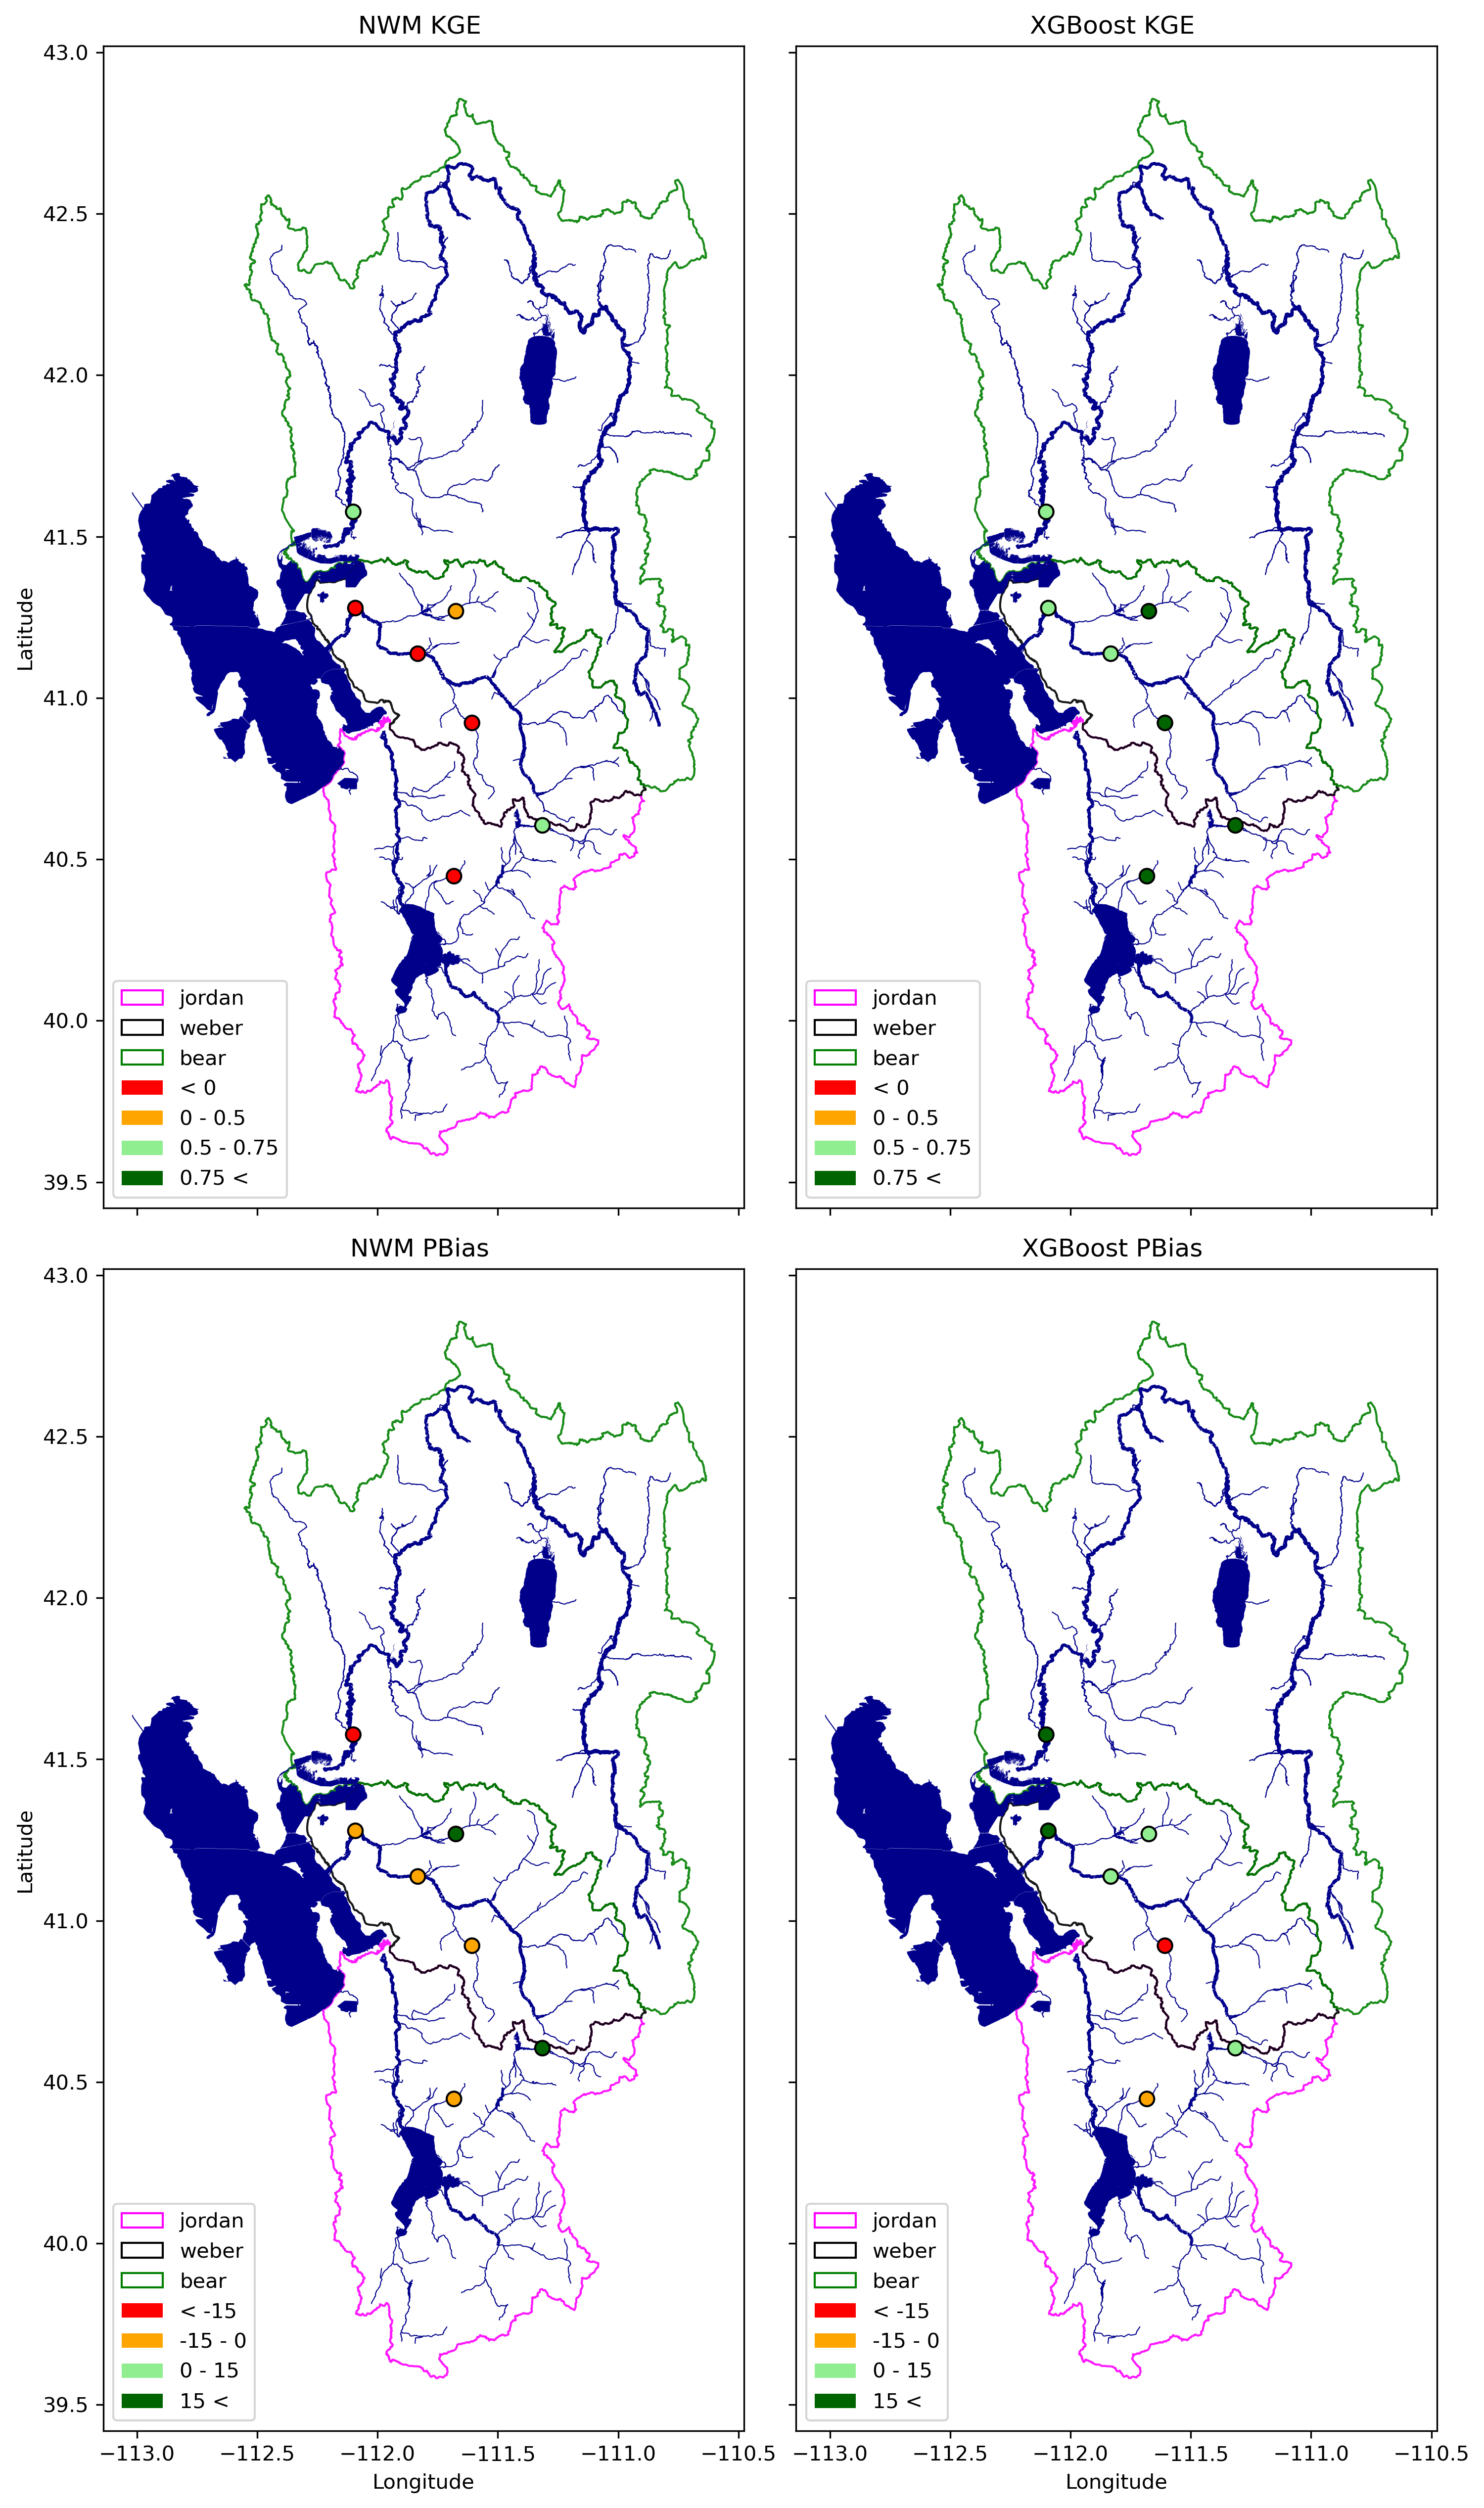

In [10]:
from matplotlib.patches import Patch

year = ['NWM KGE', 'XGBoost KGE', 'NWM PBias', 'XGBoost PBias']
name = 'Severity'
variable = ['NWM_KGE_cat', 'xgboost__KGE_cat', 'NWM_PBias_cat', 'xgboost_PBias_cat']


fig, axes = plt.subplots(2, 2, figsize=(10, 17), dpi=300, sharey=True, sharex=True)
axes = axes.flatten()

for ax_index, ax in enumerate(axes):
    colors = ['fuchsia', 'black', 'green']

    if ax_index < 2:
        df_points = EvalDF_all_rf_all[['Lat', 'Long', 'NWM_KGE_cat', 'xgboost__KGE_cat']]
    elif ax_index >= 2:
        df_points = EvalDF_all_rf_all[['Lat', 'Long', 'NWM_PBias_cat', 'xgboost_PBias_cat']]

    for file_name, color_name in zip(file_list, colors):
        if color_name == 'fuchsia':
            my_zorder = 5
        else:
            my_zorder = 1

        merged_gdf = gpd.read_file(f"{shape_input}{file_name}_merged.shp", zorder=my_zorder)

        merged_gdf.plot(ax=ax, alpha=0.9, facecolor='none', edgecolor=color_name, linewidth=1, label=file_name) 
    lats = df_points['Lat']  # Example latitudes
    lons = df_points['Long']   # Example longitudes
    values = df_points[f'{variable[ax_index]}']  # Values associated with each point

    # Create GeoDataFrame from coordinates
    points_data = gpd.GeoDataFrame({'Latitude': lats, 'Longitude': lons, 'Value': values},
                                geometry=[Point(xy) for xy in zip(lons, lats)],
                                crs="EPSG:4326")  # Define the coordinate reference system

    subset = river_gdf_bear[river_gdf_bear['StreamLeve'] == 4]
    subset.plot(ax=ax, color='darkblue', linewidth= 1.5, label=f'Stream Order', zorder=1)  # Multiply order by 2 for line width
    subset = river_gdf_bear[~(river_gdf_bear['StreamLeve'] == 4)]
    subset.plot(ax=ax, color='darkblue', linewidth= 0.5, label=f'Stream Order', zorder=1)  # Multiply order by 2 for line width


    subset = river_gdf_jordan_weber[(river_gdf_jordan_weber['StreamLeve'] == 4) & ((river_gdf_jordan_weber['StreamOrde'] == 5) | (river_gdf_jordan_weber['StreamOrde'] == 6))]
    subset.plot(ax=ax, color='darkblue', linewidth= 1.5, label=f'Stream Order', zorder=1)  # Multiply order by 2 for line width
    subset = river_gdf_jordan_weber[~((river_gdf_jordan_weber['StreamLeve'] == 4) & ((river_gdf_jordan_weber['StreamOrde'] == 5) | (river_gdf_jordan_weber['StreamOrde'] == 6)))]
    subset.plot(ax=ax, color='darkblue', linewidth= 0.5, label=f'Stream Order', zorder=1)  # Multiply order by 2 for line width

    # Define colors for each value
    # value_colors = {0: 'yellow', 1: 'orange', 2: 'red'}

    value_colors = {0: 'red', 1: 'orange', 2: 'lightgreen', 3: 'darkgreen'}


    # Plot the points GeoDataFrame with colors based on the 'Value'
    points_data.plot(ax=ax, marker='o', color=[value_colors[val] for val in points_data['Value']], markersize=50, label='Points', edgecolor='black', zorder=2)



    subset_lake_gdf_jordan_weber = lake_gdf_jordan_weber[(lake_gdf_jordan_weber['GNIS_Name'] != None) & (lake_gdf_jordan_weber['AreaSqKm'] >= 5) & ((lake_gdf_jordan_weber['FType'] == 390) | (lake_gdf_jordan_weber['FType'] == 436))]
    subset_lake_gdf_jordan_weber.plot(ax=ax, color='darkblue', linewidth= 0.5, label=f'Stream Order', zorder=1)  # Multiply order by 2 for line width



    subset_lake_gdf_bear = lake_gdf_bear[(lake_gdf_bear['GNIS_Name'] != None) & (lake_gdf_bear['AreaSqKm'] >= 5) & ((lake_gdf_bear['FType'] == 390) | (lake_gdf_bear['FType'] == 436))]
    subset_lake_gdf_bear.plot(ax=ax, color='darkblue', linewidth= 0.5, label=f'Stream Order', zorder=1)  # Multiply order by 2 for line width



    # colur_name = ['Low', 'Medium', 'High']
    if ax_index < 2:
        colur_name = ['< 0', '0 - 0.5', '0.5 - 0.75', '0.75 <']
    if ax_index >= 2:
        colur_name = ['< -15', '-15 - 0', '0 - 15', '15 <']

    # Create legend handles for sh
    # legend_handles = [Patch(facecolor='none', edgecolor=color, label=label) for color, label in zip(colors, file_list)]
    shapefile_handles = [Patch(facecolor='none', edgecolor=color, label=label) for color, label in zip(colors, file_list)]
    point_handles = [Patch(facecolor=color, edgecolor='none', label=f'{colur_name[val]}') for val, color in value_colors.items()]
    all_handles = shapefile_handles + point_handles
    # Add titles and labels if necessary
    ax.set_title(f'{year[ax_index]} ')
    if ax_index == 0 or ax_index == 2:
        ax.set_ylabel('Latitude')
    if ax_index >= 2:
        ax.set_xlabel('Longitude')

    # Show the plot
    ax.legend(handles=all_handles, loc='lower left')

plt.tight_layout()
# plt.savefig(f'{output_path_general}map_{name}_{year[0]}_{durtation_num}.png', bbox_inches='tight')
plt.show()